In [11]:
CONFIG_PATH = "configs/small_sample_sub_minority.yml"
from utils import get_config
config = get_config(CONFIG_PATH, "_curation", print_config = False)
peer_vote_option = "similar_user_opposite_vote" # "real", "real_user_opposite_vote", "similar_user_opposite_vote" # TODO:
use_voted_users_feature = config["use_voted_users_feature"]
use_voted_users_feature = False # TODO:
if use_voted_users_feature:
    print("Use peer votes as model input feature")
else:
    print("Finetune the model using peer votes")

GPU ready...
Smart using cuda:0
Finetune the model using peer votes


In [12]:
from collections import Counter, defaultdict
import os
import random
import shutil
import numpy as np
import pandas as pd
from superdebug import debug
import torch
from process_data import get_model_input
from model import get_best_model, TransformerVoter
from utils import get_user_reps, get_bool_vec, record_existing_votes
from train import evaluate_model, train_model
import sklearn.metrics
import copy

In [13]:
target, original_feature_map, categorical_features, string_features, train_data, test_data, test_data_info, train_submission_upvote_df, num_all_users = get_model_input(config)
extra_input = (categorical_features, string_features, target)

------------------ 2022-08-10 21:26:52 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/process_data.py:349 get_model_input
Loading prepared data...
------------------ 2022-08-10 21:26:52 ------------------


In [14]:
model, _ = get_best_model(config, categorical_features, string_features, original_feature_map)

------------------ 2022-08-10 21:26:55 ------------------
DEBUG: 1 vars: ['original_token_num'], at /home/TableSense/largedisk/wanrong/Curation-Modeling/model.py:248 get_tokenizer
0 / 3.  original_token_num num val: 30522
------------------ 2022-08-10 21:26:55 ------------------
------------------ 2022-08-10 21:26:55 ------------------
DEBUG: 1 vars: ['latest_token_num'], at /home/TableSense/largedisk/wanrong/Curation-Modeling/model.py:260 get_tokenizer
0 / 4.  latest_token_num num val: 153833
------------------ 2022-08-10 21:26:55 ------------------


Some weights of the model checkpoint at prajjwal1/bert-mini were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


------------------ 2022-08-10 21:26:57 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:110 load_model
Loading best model...
------------------ 2022-08-10 21:26:57 ------------------


In [15]:
print(model.device)
test_data.iloc[:2]
# !nvidia-smi

cuda:0


,SUBMISSION_ID,SUBREDDIT,CREATED_TIME,USERNAME,VOTE,TITLE,AUTHOR,#_COMMENTS,NSFW,SCORE,UPVOTED_%,LINK,SUBMISSION_TEXT,UPVOTED_USERS,DOWNVOTED_USERS
0,t3_foozz0,r/metacanada,Wed Mar 25 2020,20437,1.0,Chris Cuomo mocking Trump’s “Chinese Virus” is...,3217,14,false,60,0.91,https://www.reddit.com/r/metacanada/comments/f...,Chris Cuomo mocking Trump’s “Chinese Virus” is...,[],[]
1,t3_faxmbr,r/curlyhair,Fri Feb 28 2020,6637,1.0,If you ever doubted the CG method...,89419,19,false,364,1.00,https://www.reddit.com/r/curlyhair/comments/fa...,If you ever doubted the CG method...,[],[]


Define functions to simulate new peer votes

In [34]:
def count_new_vote_pred(peer_votes_num_acc_df, target_vote, pred_target_vote_score, peer_vote_num, peer_votes_data):
    peer_votes_num_acc_df.at[peer_vote_num, "Total"] += 1
    pred_target_vote = int(pred_target_vote_score >= 0.5)
    if pred_target_vote == target_vote:
        peer_votes_num_acc_df.at[peer_vote_num, "Acc"] += 1
        peer_votes_num_acc_df.at[peer_vote_num, "Acc confidence"] += abs(pred_target_vote_score - 0.5)
    else:
        peer_votes_num_acc_df.at[peer_vote_num, "Inacc confidence"] += abs(pred_target_vote_score - 0.5)
        
    if peer_vote_num > 0:
        majority_vote = -1
        if sum(peer_votes_data["VOTE"][:peer_vote_num])/peer_vote_num > 0.5:
            majority_vote = 1
        elif sum(peer_votes_data["VOTE"][:peer_vote_num])/peer_vote_num < 0.5:
            majority_vote = 0
        if pred_target_vote == majority_vote:
            peer_votes_num_acc_df.at[peer_vote_num, "Same as majority"] += 1


def pred_acc_peer_feature(peer_votes_num_acc_df, target_vote, target_vote_data, peer_votes_data):
    all_peer_users = peer_votes_data["USERNAME"].to_numpy()
    all_peer_votes = peer_votes_data["VOTE"].to_numpy()
    upvoted_users, downvoted_users = [], []
    for new_user_i in range(-1, len(all_peer_users)):
        peer_vote_num = new_user_i + 1
        if new_user_i >= 0:
            new_user = all_peer_users[new_user_i]
            new_vote = all_peer_votes[new_user_i]
            if new_vote == 1:
                upvoted_users.append(int(new_user))
            elif new_vote == 0:
                downvoted_users.append(int(new_user))
        target_vote_data.at[0, "UPVOTED_USERS"] = upvoted_users
        target_vote_data.at[0, "DOWNVOTED_USERS"] = downvoted_users
        pred_target_vote_score = evaluate_model(config, model, data = target_vote_data, weights = None, batch_size=1, sample_voted_users=False, extra_input = extra_input, ret="prediction", disable_tqdm=True)[0,0]
        count_new_vote_pred(peer_votes_num_acc_df, target_vote, pred_target_vote_score, peer_vote_num, peer_votes_data)

def pred_acc_peer_finetune(peer_votes_num_acc_df, target_vote, target_vote_data, peer_votes_data, n_step_per_sample=1):
    tmp_model = copy.deepcopy(model)
    # 0 peer votes
    pred_target_vote_score = evaluate_model(config, tmp_model, data = target_vote_data, weights = None, batch_size=1, sample_voted_users=False, extra_input = extra_input, ret="prediction", disable_tqdm=True)[0,0]
    count_new_vote_pred(peer_votes_num_acc_df, target_vote, pred_target_vote_score, 0, peer_votes_data)

    if len(peer_votes_data) > 0:
        for new_user_i, tmp_model in enumerate(train_model(config, tmp_model, data=peer_votes_data, weights = None, batch_size=1, epochs=1, verbose=2, validation_split=False, step_generator=True, n_step_per_sample=n_step_per_sample, extra_input = extra_input)):
            if tmp_model is None:
                break
            peer_vote_num = new_user_i + 1
            pred_target_vote_score = evaluate_model(config, tmp_model, data = target_vote_data, weights = None, batch_size=1, sample_voted_users=False, extra_input = extra_input, ret="prediction", disable_tqdm=True)[0,0]
            count_new_vote_pred(peer_votes_num_acc_df, target_vote, pred_target_vote_score, peer_vote_num, peer_votes_data)

def pred_acc_peer_feature_finetune(peer_votes_num_acc_df, target_vote, target_vote_data, peer_votes_data, n_step_per_sample=1): # conbination of the upper two
    pd.options.mode.chained_assignment = None
    all_peer_users = peer_votes_data["USERNAME"].to_numpy()
    all_peer_votes = peer_votes_data["VOTE"].to_numpy()
    target_vote_model_input = {column: target_vote_data[column] for column in target_vote_data}

    tmp_model = copy.deepcopy(model)
    # 0 peer votes
    upvoted_users, downvoted_users = [], []
    target_vote_model_input["UPVOTED_USERS"] = [upvoted_users]
    target_vote_model_input["DOWNVOTED_USERS"] = [downvoted_users]
    pred_target_vote_score = evaluate_model(tmp_model, target_vote_model_input, target_vote_model_input.get("input_ids", None), target_vote_model_input.get("token_type_ids", None), target_vote_model_input.get("attention_mask", None), target_vote_data[target].values, data = target_vote_data, weights = None, batch_size=1, max_voted_users=max_voted_users,sample_voted_users=False, ret="prediction", disable_tqdm=True)[0,0]
    count_new_vote_pred(peer_votes_num_acc_df, target_vote, pred_target_vote_score, 0, peer_votes_data)

    if len(peer_votes_data) > 0:
        peer_votes_model_input = {column: peer_votes_data[column] for column in peer_votes_data}
        # construct train model peer_votes_model_input
        peer_votes_model_input["UPVOTED_USERS"].loc[0] = upvoted_users
        peer_votes_model_input["DOWNVOTED_USERS"].loc[0] = downvoted_users
        for user_i in range(1, len(all_peer_users)):
            new_user = all_peer_users[user_i - 1] # add last user (user_i - 1) to the peer votes for user_i
            new_vote = all_peer_votes[user_i - 1]
            if new_vote == 1:
                upvoted_users.append(int(new_user))
            elif new_vote == 0:
                downvoted_users.append(int(new_user))
            peer_votes_model_input["UPVOTED_USERS"].loc[user_i] = upvoted_users
            peer_votes_model_input["DOWNVOTED_USERS"].loc[user_i] = downvoted_users
        
        # finetune the model
        upvoted_users, downvoted_users = [], []
        for new_user_i, tmp_model in enumerate(train_model(config, tmp_model, x=peer_votes_model_input, y=peer_votes_data[target].values, weights = None, batch_size=1, epochs=1, verbose=2, validation_split=False, max_voted_users=max_voted_users, step_generator=True, n_step_per_sample=n_step_per_sample)):
            if tmp_model is None:
                break
            peer_vote_num = new_user_i + 1

            # add peer votes to model input features
            new_user = all_peer_users[new_user_i]
            new_vote = all_peer_votes[new_user_i]
            if new_vote == 1:
                upvoted_users.append(int(new_user))
            elif new_vote == 0:
                downvoted_users.append(int(new_user))
            target_vote_model_input["UPVOTED_USERS"] = [upvoted_users]
            target_vote_model_input["DOWNVOTED_USERS"] = [downvoted_users]

            pred_target_vote_score = evaluate_model(tmp_model, target_vote_model_input, target_vote_model_input.get("input_ids", None), target_vote_model_input.get("token_type_ids", None), target_vote_model_input.get("attention_mask", None), target_vote_data[target].values, data = target_vote_data, weights = None, batch_size=1, max_voted_users=max_voted_users,sample_voted_users=False, ret="prediction", disable_tqdm=True)[0,0]
            count_new_vote_pred(peer_votes_num_acc_df, target_vote, pred_target_vote_score, peer_vote_num, peer_votes_data)

In [17]:
n_step_per_sample = 1
if not use_voted_users_feature:
    model.optim = torch.optim.Adam(model.parameters(), lr = 0.5 * config["learning_rate"]) # 2 还不错，5不行
    n_step_per_sample = 1

In [23]:
if peer_vote_option == "similar_user_opposite_vote":
    existing_votes, existing_user_votes, existing_user_updown_votes, existing_submission_votes = record_existing_votes(train_data)

    all_users = list(range(num_all_users))
    all_username_tokens = [f"USERNAME_{user_i}" for user_i in all_users]
    all_username_token_ids = torch.tensor(model.tokenizer.convert_tokens_to_ids(all_username_tokens))
    all_username_token_ids = all_username_token_ids.to(model.device); model = model.to(model.device)
    with torch.no_grad():
        user_embedding = model.lm_encoder.embeddings.word_embeddings(all_username_token_ids)
    # debug(all_username_tokens=all_username_tokens, all_username_token_ids=all_username_token_ids, user_embedding=user_embedding)
    all_users_reps, all_user_i_user_map = get_user_reps(all_users, all_user_embedding=user_embedding, train_data=train_data, selected_submissions = {key: None for key in set(train_data["SUBMISSION_ID"])}, user_grouping_method = "votes", do_PCA = False)

    user_similarity = sklearn.metrics.pairwise.cosine_similarity(all_users_reps)


------------------ 2022-08-10 21:42:33 ------------------
DEBUG: 1 vars: ['users_vote_sum'], at <ipython-input-23-fb57226eb7eb>:51 get_user_reps
0 / 10.  users_vote_sum Tensor size: torch.Size([31340, 1]) val: tensor([[ 1.],
        [16.],
        [ 5.],
        ...,
        [16.],
        [ 5.],
        [ 7.]])
------------------ 2022-08-10 21:42:33 ------------------
------------------ 2022-08-10 21:42:33 ------------------
DEBUG: 1 vars: ['selected_users_reps_before_PCA'], at <ipython-input-23-fb57226eb7eb>:53 get_user_reps
0 / 11.  selected_users_reps_before_PCA torch.Size with val:  torch.Size([31340, 94318])
------------------ 2022-08-10 21:42:33 ------------------
------------------ 2022-08-10 21:42:33 ------------------
DEBUG: 1 vars: ['selected_users_reps_after_PCA'], at <ipython-input-23-fb57226eb7eb>:56 get_user_reps
0 / 12.  selected_users_reps_after_PCA torch.Size with val:  torch.Size([31340, 94318])
------------------ 2022-08-10 21:42:33 ------------------


Simulate new votes coming and calculate the accuracy

In [35]:
from tqdm import tqdm

test_submissions = list(set(test_data["SUBMISSION_ID"]))
max_voted_users = 1000
peer_votes_num_acc_df = pd.DataFrame(np.zeros((max_voted_users + 1,5)), columns=['Acc', 'Acc confidence', 'Inacc confidence', 'Total', "Same as majority"])
model.to(model.device)
# test_data["UPVOTED_USERS"] = test_data["UPVOTED_USERS"].astype('object')
# test_data["DOWNVOTED_USERS"] = test_data["DOWNVOTED_USERS"].astype('object')
for submission_id in tqdm(test_submissions[:100]):
    submission_votes_data = test_data[test_data["SUBMISSION_ID"] == submission_id]
    submission_votes_data = submission_votes_data.sample(frac=1).reset_index(drop=True) # shuffle
    target_vote_data = submission_votes_data.iloc[-1:].reset_index(drop=True)
    target_vote = int(target_vote_data["VOTE"])
    peer_votes_data = submission_votes_data.iloc[:-1]
    if peer_vote_option == "real":
        pass
    elif peer_vote_option == "real_user_opposite_vote":
        peer_votes_data.loc[:,"VOTE"] = [1 - target_vote] * len(peer_votes_data)
    elif peer_vote_option == "similar_user_opposite_vote":
        target_user = int(target_vote_data["USERNAME"])
        similar_users = user_similarity[target_user].argsort()[::-1][:50]
        peer_votes_data = pd.concat([target_vote_data] * 50, axis = 0)
        peer_votes_data["USERNAME"] = similar_users
        peer_votes_data["VOTE"] = [1 - target_vote] * 50
    if use_voted_users_feature:
        pred_acc_peer_feature(peer_votes_num_acc_df, target_vote, target_vote_data, peer_votes_data)
        # pred_acc_peer_feature_finetune(peer_votes_num_acc_df, target_vote, target_vote_data, peer_votes_data, n_step_per_sample=n_step_per_sample)
    else:
        pred_acc_peer_finetune(peer_votes_num_acc_df, target_vote, target_vote_data, peer_votes_data, n_step_per_sample=n_step_per_sample)    

100%|██████████| 100/100 [05:49<00:00,  3.49s/it]


In [36]:
peer_votes_num_acc_df = peer_votes_num_acc_df[peer_votes_num_acc_df["Total"] > 0]
peer_votes_num_acc_df["Acc rate"] = peer_votes_num_acc_df["Acc"]/peer_votes_num_acc_df["Total"]
peer_votes_num_acc_df["Avg acc confidence"] = peer_votes_num_acc_df["Acc confidence"]/peer_votes_num_acc_df["Total"]
peer_votes_num_acc_df["Avg inacc confidence"] = peer_votes_num_acc_df["Inacc confidence"]/peer_votes_num_acc_df["Total"]
peer_votes_num_acc_df["Same as majority rate"] = peer_votes_num_acc_df["Same as majority"]/peer_votes_num_acc_df["Total"]
peer_votes_num_acc_df["Total scaled"] = peer_votes_num_acc_df["Total"]/max(peer_votes_num_acc_df["Total"])
peer_votes_num_acc_df

,Acc,Acc confidence,Inacc confidence,Total,Same as majority,Acc rate,Avg acc confidence,Avg inacc confidence,Same as majority rate,Total scaled
0,73.0,28.626766,8.686657,100.0,0.0,0.73,0.286268,0.086867,0.00,1.0
1,61.0,23.068484,13.106706,100.0,39.0,0.61,0.230685,0.131067,0.39,1.0
2,46.0,18.663862,18.257842,100.0,54.0,0.46,0.186639,0.182578,0.54,1.0
3,42.0,15.738959,22.553264,100.0,58.0,0.42,0.157390,0.225533,0.58,1.0
4,37.0,11.928492,25.408099,100.0,63.0,0.37,0.119285,0.254081,0.63,1.0
5,32.0,9.090655,28.408841,100.0,68.0,0.32,0.090907,0.284088,0.68,1.0
6,26.0,7.208232,31.033753,100.0,74.0,0.26,0.072082,0.310338,0.74,1.0
7,21.0,5.546565,33.042922,100.0,79.0,0.21,0.055466,0.330429,0.79,1.0
8,19.0,4.015216,34.659599,100.0,81.0,0.19,0.040152,0.346596,0.81,1.0
9,15.0,2.622104,36.154600,100.0,85.0,0.15,0.026221,0.361546,0.85,1.0


------------------ 2022-08-10 22:06:22 ------------------
DEBUG: at <ipython-input-37-15aafae776eb>:6 <module>
Acc rate
------------------ 2022-08-10 22:06:22 ------------------


<AxesSubplot:ylabel='Avg acc confidence'>

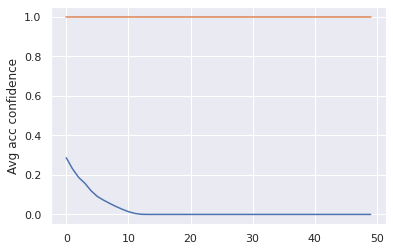

In [37]:
def convert_df_to_dict(df: pd.DataFrame):
    return {x:list(df[x]) for x in df}
import seaborn as sns

peer_votes_num_acc_df_part = peer_votes_num_acc_df.iloc[:50]
debug("Acc rate")
sns.set_theme()
sns.lineplot(data=peer_votes_num_acc_df_part, x=peer_votes_num_acc_df_part.index, y='Avg acc confidence')
sns.lineplot(data=peer_votes_num_acc_df_part, x=peer_votes_num_acc_df_part.index, y='Total scaled')
# ax.set_ylim(ymax=1)

<AxesSubplot:ylabel='Avg inacc confidence'>

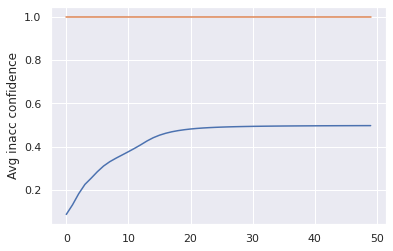

In [38]:
sns.lineplot(data=peer_votes_num_acc_df_part, x=peer_votes_num_acc_df_part.index, y='Avg inacc confidence')
sns.lineplot(data=peer_votes_num_acc_df_part, x=peer_votes_num_acc_df_part.index, y='Total scaled')

<AxesSubplot:ylabel='Acc rate'>

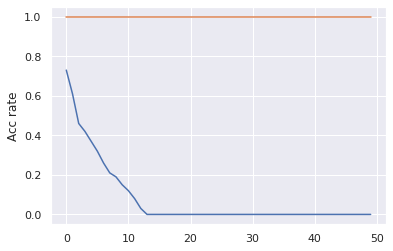

In [39]:
sns.lineplot(data=peer_votes_num_acc_df_part, x=peer_votes_num_acc_df_part.index, y='Acc rate')
sns.lineplot(data=peer_votes_num_acc_df_part, x=peer_votes_num_acc_df_part.index, y='Total scaled')

------------------ 2022-08-10 22:06:24 ------------------
DEBUG: at <ipython-input-40-256f6a6658fb>:1 <module>
Same as majority rate
------------------ 2022-08-10 22:06:24 ------------------


<AxesSubplot:ylabel='Same as majority rate'>

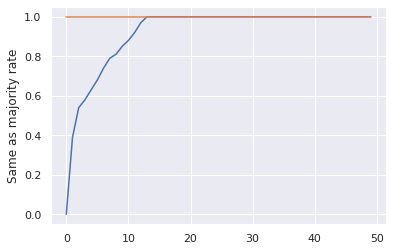

In [40]:
debug("Same as majority rate")
sns.lineplot(data=peer_votes_num_acc_df_part, x=peer_votes_num_acc_df_part.index, y='Same as majority rate')
sns.lineplot(data=peer_votes_num_acc_df_part, x=peer_votes_num_acc_df_part.index, y='Total scaled')
